##ECE M214A Project: Speaker Region Identification



In this project, we'll train a machine learning algorithm to classify speakers by regional dialect.  We will use speech samples from the Corpus of Regional African American Language (CORAAL - https://oraal.uoregon.edu/coraal) with speakers each belonging to one of five different US cities: 1) Rochester, NY (ROC), 2) Lower East Side, Manhattan, NY (LES), 3) Washington DC (DCB), 4) Princeville, NC (PRV), or 5) Valdosta, GA (VLD).

The project files can be downloaded from [this link](https://ucla.box.com/s/332ewjf1fjmod77c4r2b7c1zq8j1a9pp)

To do this, we will first extract features from the audio files and then train a classifier to predict the city of origin of the utterance's speaker.  The goal is to extract a feature that contains useful information about regional dialect characteristics.

##1. Setting up the data directories and Google Colab

Find the data for this project here: https://drive.google.com/drive/folders/1DRiIxfj5G6VzfHr1ojXxeE1YdLbae5xH?usp=sharing and store a copy in your google drive.  

Make sure that the 'project_data' folder is stored in the top level of your google drive.  Otherwise, you will need to change the corresponding paths in the remainder of the notebook.

Mount your google drive. This will give this notebook read/write access to data stored in your google drive.  You can either do this in the file browser on the left side of this notebook or by running the code snippet below. 

It is recommended that you use your UCLA google account for this project, as it has more storage than a standard google account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To run this project on your local system, replace the corresponding file paths to the locations of the project files on your local machine

## 2. Getting familiar with the data


Let's take a moment to understand the data.  The original CORAAL dataset consists of ~85 different speakers, each from one of five cities.  The audio files are names with the convention: DCB_se1_ag1_f_03.  Here, DCB is the city code, se1 denotes the socioeconomic group of the speaker, ag1 denotes the age group of the speaker, f denotes female, and 03 denotes the participant number.  These unique combinations of identifiers mark the speaker.  

The dataset has been preprocessed to only include audio segments greater than 10 seconds in length. there are a number of audio snippets of at least 10sec in length.  Those segments are numbered with the appending tag _seg_number for each segment.

You can also try listening to any segment like this:

In [ ]:
from IPython.display import Audio

sr = 44100

Audio(filename= "/content/drive/MyDrive/dsp project/project_data/train_clean/DCB_se1_ag1_f_03_1_seg_3.wav", rate=sr)
#Audio(filename="Users/swaga/Desktop/Winter_2023/214/Project/ECE_M214A_Winter_2023_Project/project_data/train_clean/DCB_se1_ag1_f_01_1_seg_3.wav", rate=sr)



The original dataset has also been split into a train and test set. The test set has been further split, with a portion corrupted with the addition of 10dB babble noise:

In [ ]:
sr = 44100

Audio(filename= "/content/drive/MyDrive/dsp project/project_data/test_noisy/LES_se0_ag3_f_01_1_seg_57.wav", rate=sr)

## 3. Feature Extraction

As a baseline, we will be using the average mfcc value over time from the Librosa Python library. Your job will be to choose better features to improve performance on both the clean and noisy data

We first define a pair of functions to create features and labels for our classification model:


In [ ]:
#To use log filterbank we need to install python_speech_features library
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5887 sha256=3364d8742abaab633fd38f619f3927c4630266f5484bc28bfa08fb776bf4810d
  Stored in directory: /root/.cache/pip/wheels/09/a1/04/08e2688d2562d8f9ff89e77c6ddfbf7268e07dae1a6f22455e
Successfully built python_speech_features


In [ ]:
import librosa
import pywt
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm
from python_speech_features import logfbank


def extract_feature(audio_file, n_mfcc=13):

  audio,fs = torchaudio.load(audio_file)
  audio = audio.numpy().reshape(-1)
  
  # Mfcc feature extraction (#13)
  mfccs = librosa.feature.mfcc(y=audio, sr=fs, n_mfcc=n_mfcc)

  #ZCR Feature extraction (#1)
  zcr = librosa.feature.zero_crossing_rate(y=audio)

  # Root mean square energy feature extraction (#1)
  rmse = librosa.feature.rms(y=audio)
  
  #log filter bank feature extraction (#26)
  fbank = logfbank(audio, 44100, nfft=2048)

  #concatinating into single vector
  feat_out = np.concatenate((np.mean(mfccs, axis=1), np.mean(zcr, axis=1), np.mean(rmse, axis=1), np.mean(fbank, axis=0)))

  return feat_out


def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DC' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  else:
    raise ValueError('invalid file name')
  return label

Let us now call these functions to extract the features and labels from the train_clean directory

In [ ]:

#First we obtain the list of all files in the train_clean directory
train_files = glob('/content/drive/MyDrive/dsp project/project_data/train_clean/*.wav')

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort() 

train_feat=[]
train_label=[]

for wav in tqdm(train_files): 
  train_feat.append(extract_feature(wav))
  train_label.append(get_label(wav))

100%|██████████| 4372/4372 [53:22<00:00,  1.37it/s]


In [ ]:
len(train_feat[0])

In [ ]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob('/content/drive/MyDrive/dsp project/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort() 

test_clean_feat=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 447/447 [04:07<00:00,  1.80it/s]


In [ ]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob('/content/drive/MyDrive/dsp project/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort() 

test_noisy_feat=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat.append(extract_feature(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 347/347 [03:56<00:00,  1.47it/s]


In [ ]:
arr=np.array(train_feat)
print(arr.shape)

(4372, 41)


## 4. Model Training and Predictions

Now we'll train the backend system to predict the regions from the input features.  We'll use an xgboosted decision tree for this.  An advantage of this model is that we can also parse the decision tree and measure the impact of different features in the end result for explainability

In [ ]:
#Install shap library
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 9.1 MB/s eta 0:00:00


In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler #Normalize

#Format input data

#Edit this variable to create a list that contains your feature names

feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]
#print("len of feat_names_mfcc= ", len(feat_names))

#####################################################



train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.  


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.668903803131991
Test Noisy Acc = 0.6858789625360231


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

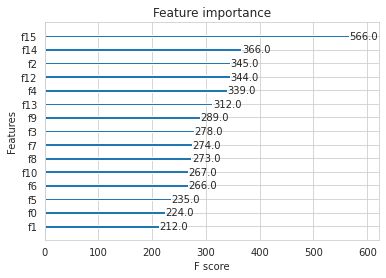

In [ ]:
# Feature importance
from xgboost import plot_importance
plot_importance(model)

(array([[0., 0., 1., 3., 0., 0., 0., 2., 0., 4.],
        [4., 3., 4., 0., 0., 0., 0., 0., 0., 0.]]),
 array([-2.73546857, -1.76192171, -0.78837485,  0.185172  ,  1.15871886,
         2.13226572,  3.10581257,  4.07935943,  5.05290629,  6.02645314,
         7.        ]),
 <a list of 2 BarContainer objects>)

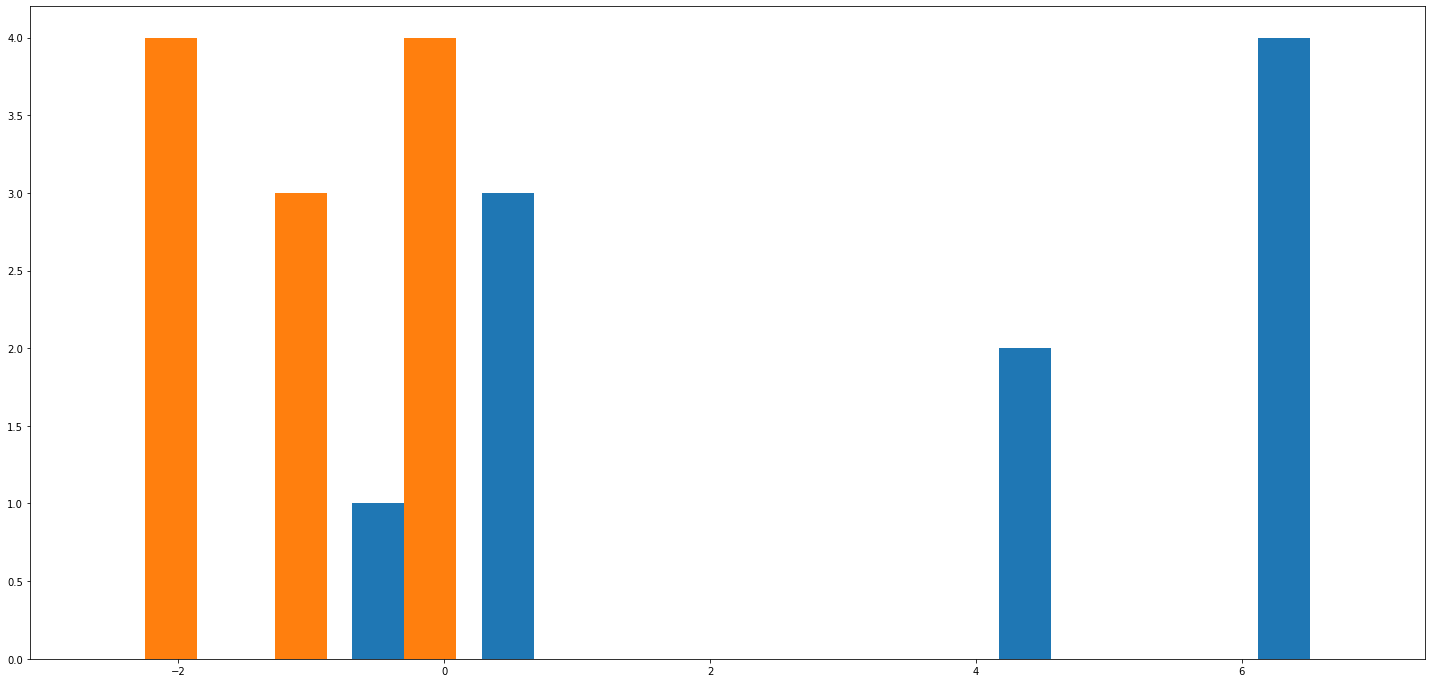

In [ ]:
import matplotlib.pyplot as plt
# Feature selection using histogram
plt.hist(np.histogram(train_feat_df[5])) # for 5th feature, like wise we can do looping over all features



To save a dataframe of features, uncomment and run the following block of code

In [ ]:
#train_feat_df.to_csv('/content/drive/MyDrive/M214A_Project/project_data/current_features.csv')
df=pd.DataFrame(train_feat_df)
df.to_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/myfeat_train.csv', index=False)
df=pd.DataFrame(test_clean_feat_df)
df.to_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/myfeat_test_clean.csv', index=False)
df=pd.DataFrame(test_noisy_feat_df)
df.to_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/myfeat_test_noisy.csv', index=False)

df=pd.DataFrame(y_train)
df.to_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/mylable_y_train.csv', index=False)
df=pd.DataFrame(y_test_clean)
df.to_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/mylable_y_test_clean.csv', index=False)
df=pd.DataFrame(y_test_noisy)
df.to_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/mylable_y_test_noisy.csv', index=False)

To Load a preexisting dataframe of features (saved from a previous notebook), run the following cell and then train the model

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 15.5 MB/s eta 0:00:00


In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler #Normalize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
train_feat_df = pd.read_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/myfeat_train.csv')
test_clean_feat_df = pd.read_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/myfeat_test_clean.csv')
test_noisy_feat_df = pd.read_csv('/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/myfeat_test_noisy.csv')

y_train=pd.read_csv("/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/mylable_y_train.csv")
y_test_clean=pd.read_csv("/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/mylable_y_test_clean.csv")
y_test_noisy=pd.read_csv("/content/drive/MyDrive/dsp project/mfcc_zcr_rmse_logfbank/mylable_y_test_noisy.csv")

In [ ]:
train_feat_df

mfcc_0      mfcc_1     mfcc_2     mfcc_3    mfcc_4     mfcc_5  \
0    -561.523804  120.514366   3.217031  -2.706900 -9.250380  -7.494580   
1    -546.168457  127.295967   7.421577   6.489375 -2.150912  -7.567279   
2    -569.576416  115.338623   9.575753  -5.976149 -5.080986 -13.719818   
3    -622.463745  126.894791  19.125463  -5.773215 -7.734212 -15.830650   
4    -557.610413  121.599808   2.857573  -8.684677 -4.438046 -12.696438   
...          ...         ...        ...        ...       ...        ...   
4367 -560.282227  165.530472  49.426727  14.181974  6.045895  12.305407   
4368 -494.134918  151.994171  44.123795  17.214214  8.042825  11.264340   
4369 -526.478210  180.663208  40.078716  15.921941 -2.079698   8.376920   
4370 -554.673218  154.316803  48.004513  21.165649  4.976439  12.679770   
4371 -500.478088  152.669937  44.625305  14.205546  3.097019  11.659517   

         mfcc_6     mfcc_7     mfcc_8     mfcc_9  ...    mfcc_31    mfcc_32  \
0    -20.736658 -11.343818  -4.274812 -14.587563  ... -14.528069 -14.420383   
1    -20.043644 -12.644693  -4.160357 -12.785785  ... -14.310547 -14.206782   
2    -19.486778 -10.981474  -8.271482 -14.621065  ... -16.005314 -15.736687   
3    -18.463333  -9.134805 -10.628955 -15.470252  ... -16.973520 -16.982647   
4    -25.651764 -11.861331  -6.504288 -14.323951  ... -15.766454 -15.561724   
...         ...        ...        ...        ...  ...        ...        ...   
4367   4.288095  -4.920248  -2.296602  -2.693539  ... -15.490808 -15.085701   
4368   1.957680  -8.717237  -8.942262  -8.323282  ... -14.298053 -13.698223   
4369   2.022379  -9.570281  -3.226587  -2.855048  ... -14.325485 -13.817303   
4370   5.052510  -4.229819  -1.183121  -3.405497  ... -14.967494 -14.341179   
4371   1.871016  -7.528543  -6.438474  -6.907691  ... -14.528388 -13.854954   

        mfcc_33    mfcc_34    mfcc_35    mfcc_36    mfcc_37    mfcc_38  \
0    -13.883172 -13.643071 -13.932298 -14.094281 -14.367142 -14.778273   
1    -13.661525 -13.697743 -13.920197 -14.373631 -14.516628 -14.983862   
2    -15.101178 -15.292661 -15.595879 -15.532802 -15.490267 -15.867712   
3    -16.374191 -15.975297 -16.004671 -16.095859 -16.108867 -16.203654   
4    -14.925863 -14.735177 -14.862117 -14.851417 -15.021353 -15.514755   
...         ...        ...        ...        ...        ...        ...   
4367 -14.928795 -14.898074 -14.783208 -15.119574 -15.407158 -15.181139   
4368 -13.637604 -13.679171 -13.749632 -14.240820 -14.653234 -14.706887   
4369 -13.883509 -14.005359 -14.056761 -14.534399 -14.803595 -14.721087   
4370 -14.271777 -14.324947 -14.391627 -14.742851 -15.080359 -14.971702   
4371 -13.756547 -13.763173 -13.650689 -14.046916 -14.514036 -14.513793   

        mfcc_39    mfcc_40  
0    -15.063626 -15.307112  
1    -15.269336 -15.448036  
2    -15.954287 -15.909537  
3    -16.174407 -16.069999  
4    -15.692844 -15.788062  
...         ...        ...  
4367 -14.446654 -13.824909  
4368 -14.193472 -13.710708  
4369 -14.155598 -13.685909  
4370 -14.338320 -13.775633  
4371 -14.023440 -13.603340  

[4372 rows x 41 columns]

Understanding the Correlation matrix and features are selected for less correlated 

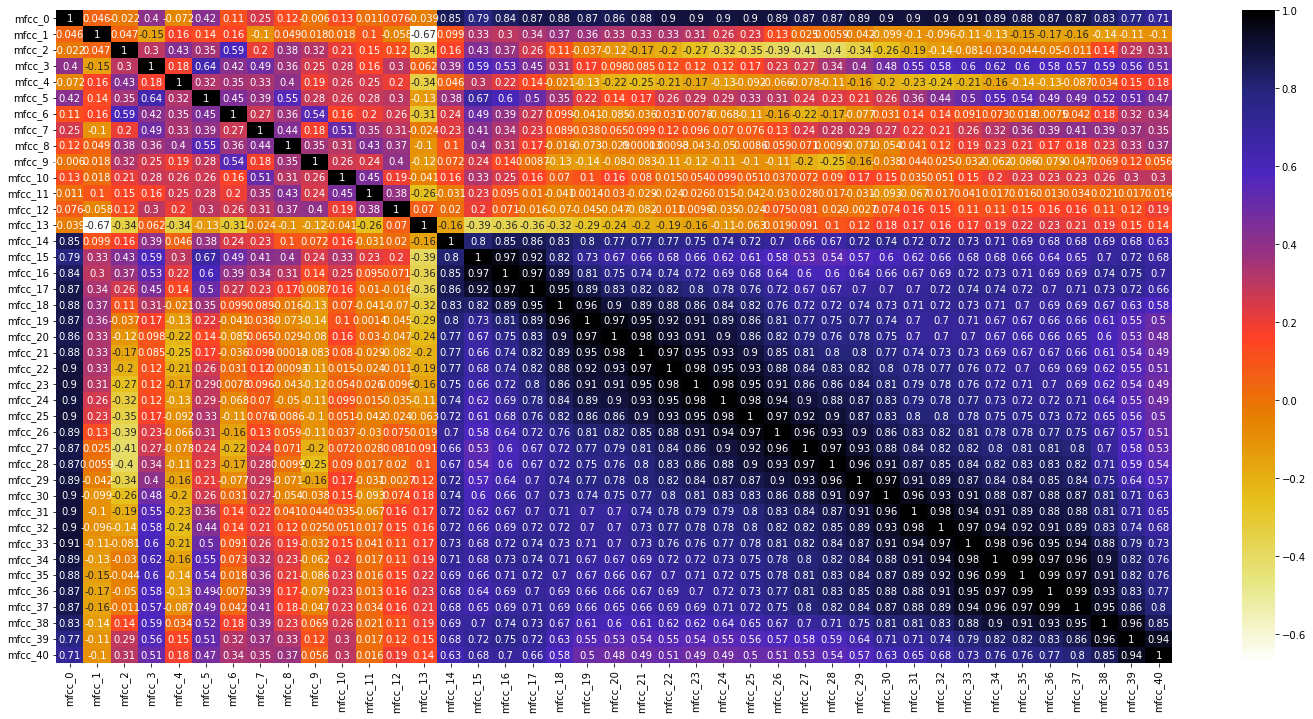

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25,12)

cor = train_feat_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)

plt.show()

Loading the saved data and chekcing the accuracy without normalization and no feature selection

In [ ]:
#loading data from saved data frame from csv file again 
import xgboost
import numpy as np
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler #Normalize
from sklearn.inspection import permutation_importance

feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]

train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
y_train=np.stack(train_label)

test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
y_test_clean=np.stack(test_clean_label)

test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
y_test_noisy=np.stack(test_noisy_label)

model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))
print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))
print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))



Train Clean Acc = 1.0
Test Clean Acc = 0.668903803131991
Test Noisy Acc = 0.6858789625360231


Permutaion Feature selection Methods

In [ ]:

# Use permutation feature importance to rank the importance of each feature
perm_importance = permutation_importance(model, train_feat_df, y_train)
perm_importance_ranking = np.argsort(perm_importance.importances_mean)[::-1]
print("Permutation feature importance ranking:")
print(train_feat_df.columns[perm_importance_ranking])

# Use feature importance ranking to rank the importance of each feature
feat_importance = model.feature_importances_
feat_importance_ranking = np.argsort(feat_importance)[::-1]
print("Feature importance ranking:")
print(train_feat_df.columns[feat_importance_ranking])


Train Clean Acc = 1.0
Test Clean Acc = 0.668903803131991
Test Noisy Acc = 0.6858789625360231

Permutation feature importance ranking:

Index(['mfcc_39', 'mfcc_15', 'mfcc_40', 'mfcc_12', 'mfcc_11', 'mfcc_5',
       'mfcc_37', 'mfcc_2', 'mfcc_13', 'mfcc_10', 'mfcc_3', 'mfcc_38',
       'mfcc_6', 'mfcc_14', 'mfcc_1', 'mfcc_8', 'mfcc_16', 'mfcc_36', 'mfcc_0',
       'mfcc_9', 'mfcc_21', 'mfcc_22', 'mfcc_35', 'mfcc_34', 'mfcc_33',
       'mfcc_4', 'mfcc_32', 'mfcc_31', 'mfcc_7', 'mfcc_30', 'mfcc_29',
       'mfcc_28', 'mfcc_27', 'mfcc_26', 'mfcc_25', 'mfcc_24', 'mfcc_23',
       'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20'],
      dtype='object')

Feature importance ranking:

Index(['mfcc_18', 'mfcc_0', 'mfcc_15', 'mfcc_24', 'mfcc_35', 'mfcc_39',
       'mfcc_2', 'mfcc_28', 'mfcc_11', 'mfcc_1', 'mfcc_37', 'mfcc_12',
       'mfcc_23', 'mfcc_40', 'mfcc_3', 'mfcc_38', 'mfcc_5', 'mfcc_36',
       'mfcc_9', 'mfcc_29', 'mfcc_31', 'mfcc_14', 'mfcc_8', 'mfcc_10',
       'mfcc_4', 'mfcc_21', 'mfcc_22', 'mfcc_6', 'mfcc_30', 'mfcc_13',
       'mfcc_16', 'mfcc_32', 'mfcc_7', 'mfcc_34', 'mfcc_26', 'mfcc_33',
       'mfcc_19', 'mfcc_25', 'mfcc_20', 'mfcc_27', 'mfcc_17'],
      dtype='object')

To see how important with value of importance for the above features 

In [ ]:
# get feature importances
importances = model.feature_importances_

# create a dataframe of feature names and importances
feat_importances = pd.DataFrame({'feature':feat_names, 'importance':importances})

# sort the dataframe by importance
feat_importances = feat_importances.sort_values('importance', ascending=False)

# print the top 10 features
print(feat_importances.head(20))


    feature  importance
18  mfcc_18    0.206903
0    mfcc_0    0.137987
15  mfcc_15    0.136508
24  mfcc_24    0.058520
35  mfcc_35    0.051480
39  mfcc_39    0.041089
2    mfcc_2    0.030011
28  mfcc_28    0.029350
11  mfcc_11    0.023962
1    mfcc_1    0.022707
37  mfcc_37    0.017898
12  mfcc_12    0.015923
23  mfcc_23    0.015665
40  mfcc_40    0.015598
3    mfcc_3    0.014916
38  mfcc_38    0.013990
5    mfcc_5    0.012959
36  mfcc_36    0.012908
9    mfcc_9    0.010992
29  mfcc_29    0.010693


This is the plot to show above features graphically foe better understanding

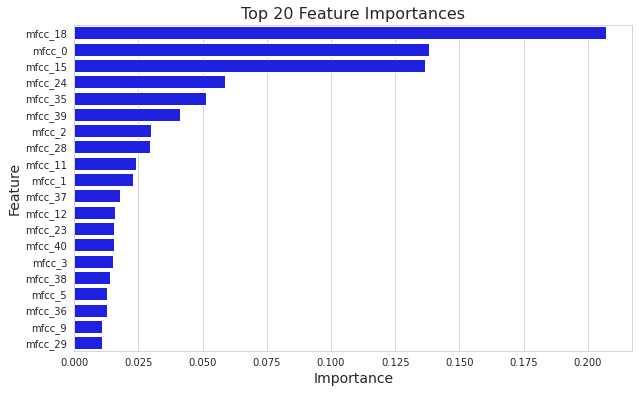

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Plot feature importances
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=feat_importances.head(20), color='blue')
plt.title("Top 20 Feature Importances", fontsize=16)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.show()

Our Final Balanced Model this can be run directly after running the base model once

In [ ]:
import xgboost
import numpy as np
import shap
import pandas as pd
from sklearn.preprocessing import StandardScaler #Normalize


#Edit this variable to create a list that contains your feature names

feat_names=['mfcc_' +str(n) for n in range(len(train_feat[0]))]
#print("len of feat_names_mfcc= ", len(feat_names))

#####################################################



train_feat_df = pd.DataFrame(data=np.stack(train_feat), columns=feat_names)
#important features
train_feat_df=train_feat_df[['mfcc_0','mfcc_14', 'mfcc_15', 'mfcc_17', 'mfcc_24', 'mfcc_2', 'mfcc_11', 'mfcc_1', 'mfcc_37','mfcc_39']]
#Normalizing
train_feat_df = StandardScaler().fit_transform(train_feat_df)
y_train=np.stack(train_label)


test_clean_feat_df = pd.DataFrame(data=np.stack(test_clean_feat), columns=feat_names)
#important features
test_clean_feat_df=test_clean_feat_df[['mfcc_0','mfcc_14', 'mfcc_15', 'mfcc_17', 'mfcc_24', 'mfcc_2', 'mfcc_11', 'mfcc_1', 'mfcc_37','mfcc_39']]
#Normalizing
test_clean_feat_df = StandardScaler().fit_transform(test_clean_feat_df)
y_test_clean=np.stack(test_clean_label)


test_noisy_feat_df = pd.DataFrame(data=np.stack(test_noisy_feat), columns=feat_names)
#important features
test_noisy_feat_df=test_noisy_feat_df[['mfcc_0','mfcc_14', 'mfcc_15', 'mfcc_17', 'mfcc_24', 'mfcc_2', 'mfcc_11', 'mfcc_1', 'mfcc_37','mfcc_39']]
#Normalizing
test_noisy_feat_df = StandardScaler().fit_transform(test_noisy_feat_df)
y_test_noisy=np.stack(test_noisy_label)


#you could just pass in the matrix of features to xgboost
#but it looks prettier in the shap explainer if you format it
#as a dataframe.  


model = xgboost.XGBClassifier()
model.fit(train_feat_df,y_train)

print("Train Clean Acc =", np.sum(y_train==model.predict(train_feat_df))/len(y_train))

print("Test Clean Acc =", np.sum(y_test_clean==model.predict(test_clean_feat_df))/len(y_test_clean))

print("Test Noisy Acc =", np.sum(y_test_noisy==model.predict(test_noisy_feat_df))/len(y_test_noisy))


Train Clean Acc = 1.0
Test Clean Acc = 0.8120805369127517
Test Noisy Acc = 0.7550432276657061


Train Clean Acc = 1.0
Test Clean Acc = 0.8120805369127517
***Test Noisy Acc = 0.7550432276657061***

'mfcc_0','mfcc_14', 'mfcc_15', 'mfcc_17', 'mfcc_24', 'mfcc_2', 'mfcc_11', 'mfcc_1', 'mfcc_37','mfcc_39'


## 5. Interpreting Results and Explainability

To see the impact different features have on the model, we create a plot of the feature importances. The features are listed top to bottom in order of how important they were to the decision.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


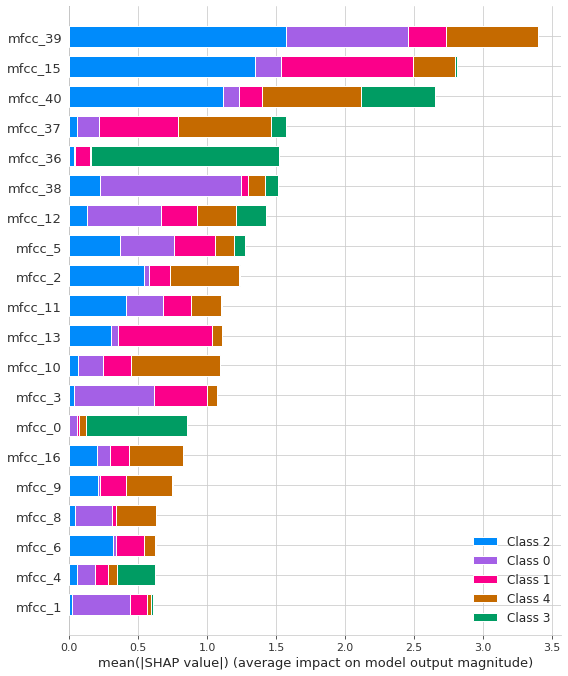

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_feat_df)
shap.summary_plot(shap_values, train_feat_df)

And we can see a confusion matrix of the mispredictions

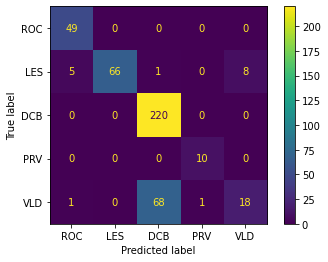

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model.predict(test_clean_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

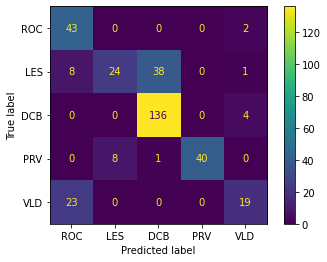

In [ ]:

confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model.predict(test_noisy_feat_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD'])
cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

print("precision",precision_score(y_test_clean, model.predict(test_clean_feat_df), average=None ))
print("recall",recall_score(y_test_clean, model.predict(test_clean_feat_df), average=None ))
print("accuracy",accuracy_score(y_test_clean, model.predict(test_clean_feat_df)))

precision [0.89090909 1.         0.76124567 0.90909091 0.69230769]
recall [1.         0.825      1.         1.         0.20454545]
accuracy 0.8120805369127517


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_clean, model.predict(test_clean_feat_df), target_names=['ROC','LES','DCB','PRV','VLD']))

              precision    recall  f1-score   support

         ROC       0.89      1.00      0.94        49
         LES       1.00      0.82      0.90        80
         DCB       0.76      1.00      0.86       220
         PRV       0.91      1.00      0.95        10
         VLD       0.69      0.20      0.32        88

    accuracy                           0.81       447
   macro avg       0.85      0.81      0.80       447
weighted avg       0.81      0.81      0.77       447



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_noisy, model.predict(test_noisy_feat_df), target_names=['ROC','LES','DCB','PRV','VLD']))

              precision    recall  f1-score   support

         ROC       0.58      0.96      0.72        45
         LES       0.75      0.34      0.47        71
         DCB       0.78      0.97      0.86       140
         PRV       1.00      0.82      0.90        49
         VLD       0.73      0.45      0.56        42

    accuracy                           0.76       347
   macro avg       0.77      0.71      0.70       347
weighted avg       0.77      0.76      0.73       347

